In [4]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import cmath
from random import randint
from numpy import linalg

L = 0.3/2
c = 340.
T = 2.*L/c
jitt = 0.01*T

#Perceptron parameters
tau_m = 1/T
v_th = 1.
calcSteps = 200

decayFactor = 15.
W_scaling = 1.1

printPerceptron = False
sideImg = 0.7 

N = len(R)*len(alpha)


weights = [W_scaling * v_th / 8.  for i in range(8)]
weightsDetector = [weights for n in range(N)]


def generatePositions(angles, radii):
    positions = []
    for r in radii:
        for a in angles:

            u = r*np.cos(a)
            v = r*np.sin(a)

            positions.append([u,v])
            
    return positions

R = [0.3,0.6]
alpha = np.linspace(0.,2*np.pi,num=10, endpoint = False)
positions = generatePositions(alpha,R)

angles = [v*2*math.pi/8. for v in range(0,8)]
sensorPositions = [(math.cos(a)*L, math.sin(a)*L) for a in angles]


def singlePositionToSpikes(sensorPositions, preyPosition, jitter = jitt, speed = c):
    posDelays = []
    for sensPos in sensorPositions:
        xdist = sensPos[0] - preyPosition[0]
        ydist = sensPos[1] - preyPosition[1]
        dist = math.sqrt(xdist*xdist + ydist*ydist)
        Dt = dist/speed  + jitter*np.random.rand()
        posDelays.append(Dt)
        
    refTime = min(posDelays)
    #print(posDelays)
    relativeArrival = [pos - refTime for pos in posDelays]
    #print(relativeArrival)
    return relativeArrival
    #return posDelays

def setStartingTimeAtZero(times):
    t_0 = min(times)
    t_list = [t - t_0 for t in times]
    return t_list

def recoverSynapseParamsOnePattern(patternToDetect):
    delays = [T - tp for tp in patternToDetect]
    weights = W_scaling * v_th / len(patternToDetect)*np.ones(len(patternToDetect))
    return (delays, weights)


#EVENT_BASED PERCEPTRON, return detection and max. membrane potential
def LIF_perceptron(synapticDelays, synapticWeights, spikeTimes, T=T):  
    spikeArrival = [synDel + time for synDel, time in zip(synapticDelays, spikeTimes)]

    time = np.linspace(0.,2.5*T,calcSteps)
    spikeBins = np.digitize(spikeArrival,time)
    LIF_input = np.zeros(calcSteps)
    for idx in range(len(synapticDelays)):
        timeBinIdx = spikeBins[idx]
        weight = synapticWeights[idx]
        currentInput = LIF_input[timeBinIdx+1]
        #print('Time = '+str(timeBinIdx)+'  Weight '+ str(weight)+ '  Current Input '+ str(currentInput))
        LIF_input[timeBinIdx+1] =  currentInput + weight
        
    v = 0
    dt = 1/calcSteps

    decay = np.exp(-dt*decayFactor)
    memPot = np.zeros(calcSteps)
    for tIdx in range(calcSteps):
        v = v * decay + LIF_input[tIdx]
        memPot[tIdx] = v

    if printPerceptron == True:
        plt.plot(time, memPot)
        plt.ylabel('V')
        plt.xlabel('Time')
        plt.title('Time perceptron')
        plt.show()
    
    v_max = max(memPot)
    fire = v_max > v_th
    return (fire, v_max)

def positionToDelays(preyPos):
    patternToLearn = singlePositionToSpikes(sensorPositions, preyPos)
    synDelays, synWeights = recoverSynapseParamsOnePattern(patternToLearn)
    return synDelays

def delaysPerPosition(positionsList, speed = c):
    timeWind = 2.*L/speed
    delays = [positionToDelays(pos) for pos in positionsList]
    return delays

def findDetector(spikePattern, synDelays, synWeights):
    firingNeurons = []
    v_max_list = []
    for n in range(N):
        fired, vmax = LIF_perceptron(synDelays[n], synWeights[n], spikePattern)
        if fired:
            firingNeurons.append(n)
            v_max_list.append(vmax)
            
        #print(v_max_list)
    #print(v_max_list)
    
    return firingNeurons

def plotPositions(positions):
    
    siz = 10
    plt.figure(figsize=(siz,siz))
    x_pos = [p[0] for p in positions]
    y_pos = [p[1] for p in positions]
    
    shift = -0.02#siz/10
    x_corrected = [x - shift for x in x_pos]
    y_corrected = [y - shift for y in y_pos]
    plt.scatter(x_corrected,y_corrected,s=2000, alpha = 0.4)
    
    for pIdx in range(len(positions)):
        plt.text(x_pos[pIdx], y_pos[pIdx], str(pIdx), fontSize= 20)
    
    plt.show()
    
def V_LI(synapticDelays, synapticWeights, spikeTimes, T=T):
    spikeArrival = [synDel + time for synDel, time in zip(synapticDelays, spikeTimes)]

    time = np.linspace(0.,2.5*T,calcSteps)
    spikeBins = np.digitize(spikeArrival,time)
    LIF_input = np.zeros(calcSteps)
    for idx in range(len(synapticDelays)):
        timeBinIdx = spikeBins[idx]
        weight = synapticWeights[idx]
        currentInput = LIF_input[timeBinIdx+1]
        #print('Time = '+str(timeBinIdx)+'  Weight '+ str(weight)+ '  Current Input '+ str(currentInput))
        LIF_input[timeBinIdx+1] =  currentInput + weight
        
    v = 0
    dt = 1/calcSteps

    decay = np.exp(-dt*decayFactor)
    memPot = np.zeros(calcSteps)
    for tIdx in range(calcSteps):
        v = v * decay + LIF_input[tIdx]
        memPot[tIdx] = v

    return memPot

def plotLI(synapticDelays, synapticWeights, spikeTimes, T=T):  
    memPot = V_LI(synapticDelays, synapticWeights, spikeTimes)
    if printPerceptron == True:
        plt.plot(time, memPot)
        plt.ylabel('V')
        plt.xlabel('Time')
        plt.show()


    
def positionToImgCoordinates(x,y):
    phi = np.arctan2(y, x)
    rad = math.sqrt(x*x + y*y)
    outerCircle = int(rad>0.5)
    x_img = 0.5 + (x-0.035)/1.8 + 0.06*np.cos(phi+outerCircle*math.pi/2)
    y_img = 0.5 + (y-0.035)/1.8 + 0.06*np.sin(phi+outerCircle*math.pi/2)
    return (x_img, y_img)
    
def plotPositionsWithMemPot(positions, selectedPos = [], memPotentials = []):
    plt.figure(figsize=(40,40))
    x_pos = [p[0] for p in positions]
    y_pos = [p[1] for p in positions]
    plt.scatter(x_pos,y_pos,s=5000)
    
    x_sel = [p[0] for p in selectedPos]
    y_sel = [p[1] for p in selectedPos]
    plt.scatter(x_sel, y_sel, c='r', s=10000)
    
    plt.axis([-sideImg,sideImg,-sideImg, sideImg])
    
    memCount = 0
    for sp in positions:
        x_pos, y_pos = positionToImgCoordinates(sp[0], sp[1])
        a = plt.axes([x_pos, y_pos, .07, .07])
        #print(memPotentials)
        plt.plot(memPotentials[memCount])
        plt.ylim(0,1.1)
        memCount = memCount+1
    
    plt.show()

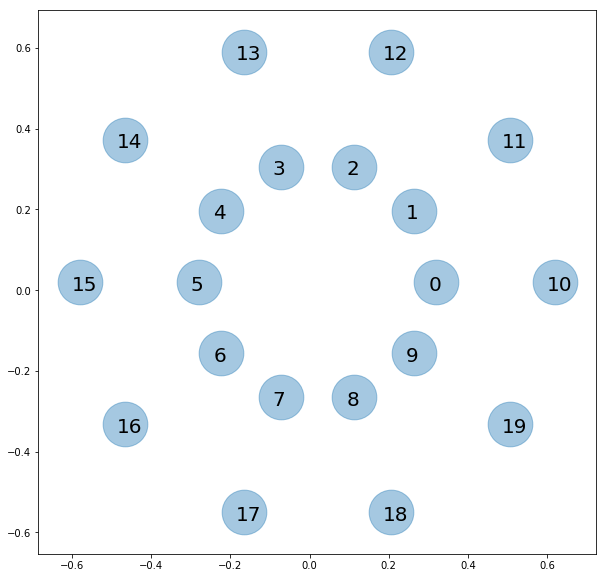

10


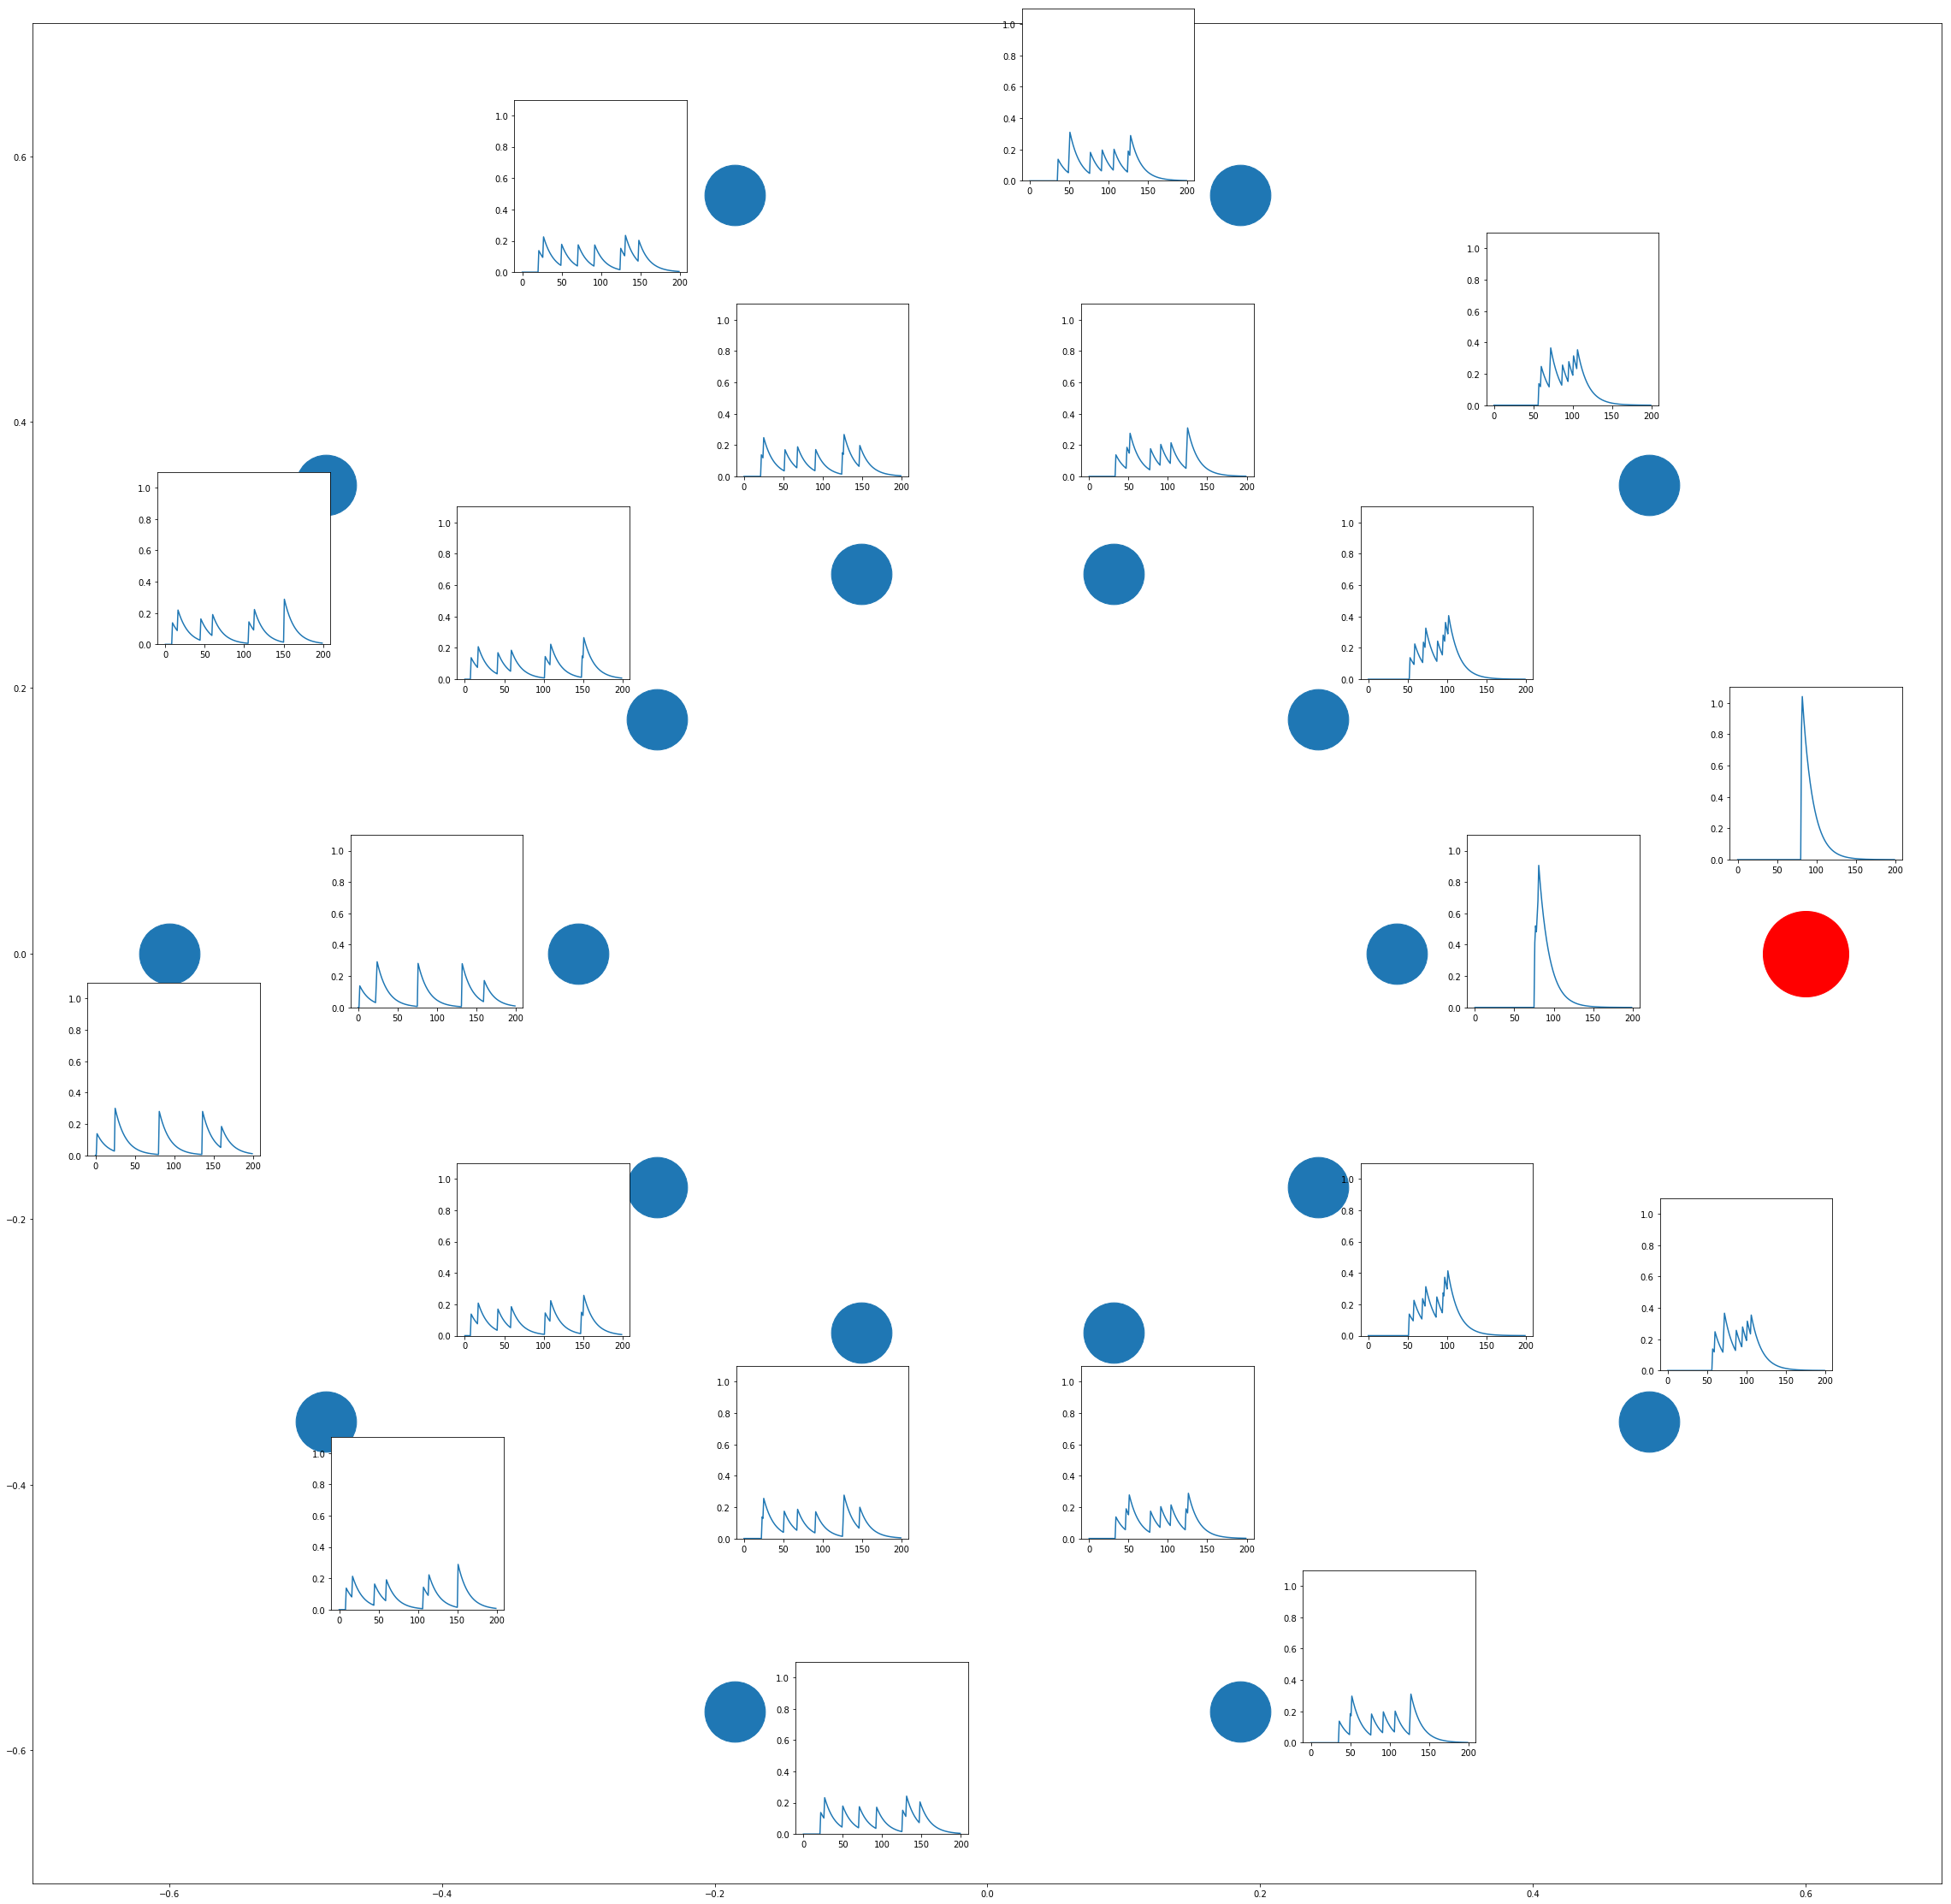

In [15]:
plotPositions(positions)
    
idxToDetect = int(input())#randint(0,N-1)

delaysDetector = delaysPerPosition(positions)
    
positionToDetect = positions[idxToDetect]
spikePattern = singlePositionToSpikes(sensorPositions, positionToDetect)

indexSelectedPos = findDetector(spikePattern, delaysDetector, weightsDetector)
selectedPos = [positions[idxSel] for idxSel in indexSelectedPos]

spikePatternList = [singlePositionToSpikes(sensorPositions, pos) for pos in positions]

memPotList = [V_LI(delaysDetector[idx], weightsDetector[idx], spikePattern) for idx in range(len(positions)) ]
plotPositionsWithMemPot(positions, selectedPos, memPotList)